House Prices - Random Forest
===

Reprenons où nous en étions arrivé mercredi :

In [1]:
%matplotlib inline
%run labs-1.py

train_df = pd.read_csv('../data/ames/train.csv')
test_df = pd.read_csv('../data/ames/test.csv')

train_X, train_y = train_df.iloc[:, 1:-1], train_df.iloc[:, -1]
test_X = test_df.iloc[:, 1:]

train_Id, test_Id = train_df['Id'], test_df['Id']

all_X = preprocess(pd.concat([train_X, test_X]))
train_X = all_X.iloc[:len(train_X), :]
test_X = all_X.iloc[len(train_X):, :]

Nous avons maintenant prétraité et visualisé les données. Il nous reste à comprendre comment entraîner un modèle, régler ses hyper-paramètres et en tirer les informations qui peuvent nous intéresser.

Notre modèle de choix dans le cadre de ce TP sera Random Forest, pour tester quelques uns de ses atouts.

Il nous reste cependant avant de commencer un dernier détail de pré-processing à régler : nous avions détecté une asymétrie positive de la variable de sortie (`SalePrice`) sans la corriger.

- log-transformez la variable `train_y` afin de corriger son asymétrie positive

Notez qu'il ne sert à rien de transformer les autres variables car, comme vous l'avez peut-être remarqué quand nous avons détaillé les algorithmes en cours, les arbres de décision sont insensibles aux transformations monotones de leurs variables d'entrée

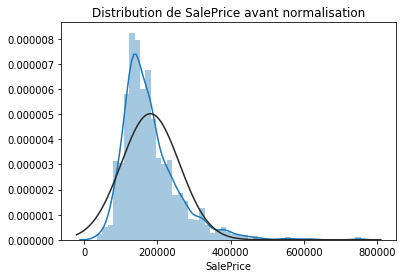

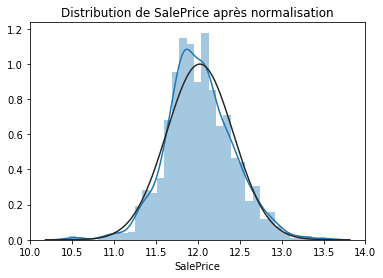

In [2]:
sns.distplot(train_y, fit=scipy.stats.norm)
plt.title('Distribution de SalePrice avant normalisation')
plt.show()

train_y = np.log1p(train_y)

sns.distplot(train_y, fit=scipy.stats.norm)
plt.title('Distribution de SalePrice après normalisation')
plt.show()

Nos données étant maintenant prêtes, il nous faut trouver une méthode d'évaluation correcte pour nos modèles.

- utilisez [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) pour écrire une fonction `score` qui évaluera un modèle avec une 5-fold cross-validation qui utilise la root mean squared error.

In [3]:
def score(model):
    rmse = np.sqrt(-sklearn.model_selection.cross_val_score(
        model, train_X, train_y, cv=5, scoring='neg_mean_squared_error'))
    return rmse.mean(), rmse.std() * 2

Nous avons maintenant un outil d'évaluation fiable. Nous pouvons commencer à expérimenter avec des modèles de régression avancés.

- testez un [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) initialisé aux valeurs par défaut : ça sera une baseline à surpasser.

In [4]:
print(score(sklearn.ensemble.RandomForestRegressor()))

(0.15371082700831662, 0.017169562937635083)


Une des premières choses à faire pour tirer le plus possible d'un modèle est de régler ses paramètres.

- utilisez [`RandomizedSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) sur les paramètres `n_estimators`, `max_features`, `max_depth` et `min_samples_leaf` pour trouver une bonne configuration de paramètres.

In [5]:
rscv = sklearn.model_selection.RandomizedSearchCV(
    estimator=sklearn.ensemble.RandomForestRegressor(),
    param_distributions={
        'n_estimators': range(50, 250, 10),
        'max_features': ['auto', 'sqrt'],
        'max_depth': [8, 10, 20, 50],
        'min_samples_leaf': [1, 2, 3, 4, 5]
    },
    n_iter = 20,
    scoring='neg_mean_squared_error',
    cv = 3,
    random_state=42,
    n_jobs=-1,
    return_train_score=True)

rscv.fit(train_X, train_y)
best_params = rscv.best_params_
print(best_params)

{'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50}


Maintenant que vous connaissez une bonne combinaison de paramètres, utilisez la pour créer une nouvelle forêt et testez son score pour voir si celui-ci est meilleur que notre baseline.

In [6]:
rfr = sklearn.ensemble.RandomForestRegressor(
    oob_score=True,
    n_jobs=-1,
    **rscv.best_params_)

print(score(rfr))

(0.14340600577184945, 0.0178719733371532)


Ce modèle étant satisfaisant pour l'instant, intéressons-nous aux possibilités qu'offre Random Forest. Il est par exemple possible de calculer l'importance des features en observant la chute moyenne en erreur (ou impureté) qu'elles entraînent.

- utilisez l'attribut `feature_importances_` de votre Random Forest pour comprendre quelles sont les features les plus importantes

275
importance    0.10955
Name: GrLivArea, dtype: float64


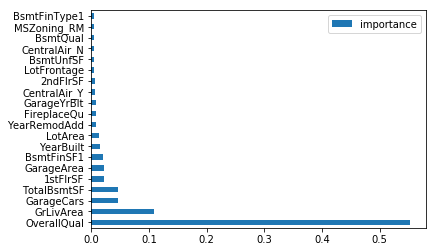

In [7]:
rfr.fit(train_X, train_y)

importances = pd.DataFrame(
    {'importance': rfr.feature_importances_},
    index=train_X.columns)
print(len(importances))
print(importances.loc['GrLivArea'])
importances = importances.sort_values(by='importance', ascending=False)
importances = importances.iloc[:20, :]
importances.plot.barh()
plt.show()

Il est aussi possible de mesurer la généralisation d'une forêt sur les exemples que ses arbres n'ont pas pu voir de par le processus de boostrapping.

- utilisez l'attribut `oob_score_` pour mesurer l'impact du nombre d'arbres dans la forêt. Pour cela, entraînez un modèle avec 1 à 20 arbres et reportez le score OOB dans un plot. L'OOB score que calcule `scikit-learn` est le score R². De bonnes ressources pour l'interpréter sont disponibles sur stats.stackexchange : [ici](https://stats.stackexchange.com/questions/70704/interpreting-out-of-bag-error-estimate-for-randomforestregressor) et [là](https://stats.stackexchange.com/questions/133406/is-a-negative-oob-score-possible-with-scikit-learns-randomforestregressor).


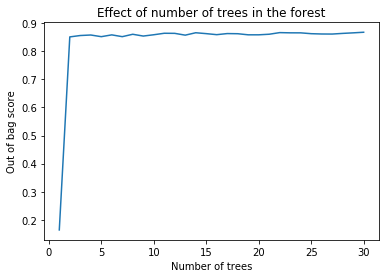

In [8]:
oob_scores = []
for i in range(21, 51):
    rfr.set_params(n_estimators=i)
    rfr.fit(train_X, train_y)
    # Record the OOB error for each `n_estimators=i` setting.
    # OOB score = R² score.
    oob_scores.append(rfr.oob_score_)

plt.title('Effect of number of trees in the forest')
plt.xlabel('Number of trees')
plt.ylabel('Out of bag score')
plt.plot(range(1, len(oob_scores) + 1), oob_scores)

On va maintenant s'intéresser aux propriétés d'analyse de la variance des random forests.

- utilisez chacun des arbres de votre forêt (ils sont contenus dans l'attribut `estimators_`) pour prédire un intervalle plutôt qu'un point précis qui correspondra à un quantile défini

In [9]:
rfr.set_params(n_estimators=100)
rfr.fit(train_X, train_y)

def predict_quantile(tree, X, lower, upper):
    estimators = tree.estimators_
    predicts = np.expm1(np.array([e.predict(X)
                                  for e in estimators]))
    return np.percentile(predicts, [lower, upper], axis=0)

quantiles = predict_quantile(rfr, train_X, 15, 85).T
predicted = np.expm1(rfr.predict(train_X))

quantiles_df = pd.DataFrame({
    'lower': quantiles[:, 0],
    'upper': quantiles[:, 1],
    'iqr': quantiles[:, 1] - quantiles[:, 0],
    'yh': predicted,
    'y': np.expm1(train_y)
})

# normalizing by output so that big uncertainties on small outputs
# are still considered as big uncertainties.
quantiles_df['normalized_iqr'] = (quantiles_df['iqr']
                                  / quantiles_df['yh'])

# sorting by price
quantiles_df = quantiles_df.sort_values(by='y')

# adding original data
quantiles_df = pd.concat([quantiles_df, train_X],
                          axis=1,
                          join='inner')

Cette analyse permet de trouver les exemples qui ont entraîné le plus d'incertitude dans notre forêt.

- retrouvez ces instances dans votre training set. Les avez-vous déjà vues ?

In [10]:
most_uncertain = quantiles_df.sort_values(by='normalized_iqr',
                                          ascending=False)
most_uncertain[['GrLivArea', 'OverallQual', 'normalized_iqr', 'iqr', 'y', 'yh']]

,GrLivArea,OverallQual,normalized_iqr,iqr,y,yh
1298,5642,10,1.466741,393932.446651,160000.0,268576.605012
523,4676,10,1.419840,421509.010003,184750.0,296870.867455
30,1317,4,1.133410,68432.388048,40000.0,60377.409789
916,480,2,1.028040,51292.798111,35311.0,49893.784492
495,720,4,0.958380,47375.026420,34900.0,49432.426100
968,968,3,0.930715,48753.486453,37900.0,52382.834319
410,1276,5,0.827307,75527.865186,60000.0,91293.603374
812,1044,5,0.765436,54225.053715,55993.0,70842.018662
1349,2358,8,0.735335,125453.054454,122000.0,170606.649767
688,1419,8,0.649866,183534.840196,392000.0,282419.443807


Les instances les plus incertaines sont celles qui paraissaient être anormales en fin d'exploration des données.

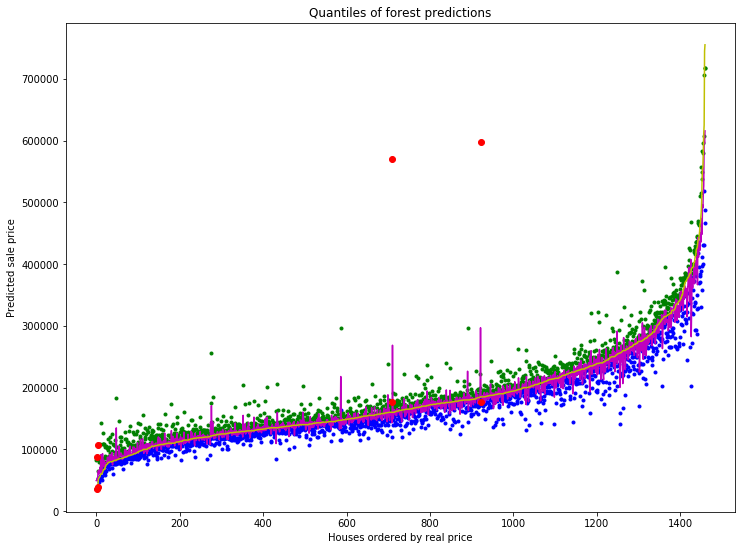

In [11]:
idx = range(len(quantiles_df))
x = quantiles_df

certain = quantiles_df['normalized_iqr'] <= 1
uncertain = quantiles_df['normalized_iqr'] > 1

idx_certain = np.flatnonzero(certain)
idx_uncertain = np.flatnonzero(uncertain)

x_certain = quantiles_df[certain]
x_uncertain = quantiles_df[uncertain]


fig, ax = plt.subplots(figsize=(12, 9))
plt.plot(idx_certain, x_certain['lower'], '.b')
plt.plot(idx_certain, x_certain['upper'], '.g')
plt.plot(idx, x['yh'], 'm')
plt.plot(idx, x['y'], 'y')
plt.plot(idx_uncertain, x_uncertain['lower'], 'or')
plt.plot(idx_uncertain, x_uncertain['upper'], 'or')
plt.title('Quantiles of forest predictions')
plt.ylabel('Predicted sale price')
plt.xlabel('Houses ordered by real price')
plt.show()